<img src="logo_ue.png" width="400"/>


# ANEXO 6
# 3. DESARROLLO DEL PROYECTO - 
## Análisis de resultados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from wordcloud import WordCloud



In [2]:
df_iniciativas = pd.read_excel("iniciativas_preprocesadas.xlsx")
df = pd.read_csv('vinculacion_semantica_resultados.csv')

In [3]:
df_iniciativas = df_iniciativas.rename(columns={"código_iniciativa": "codigo_iniciativa"})
df = df.merge(df_iniciativas[["codigo_iniciativa", "pilar"]], on="codigo_iniciativa", how="left")


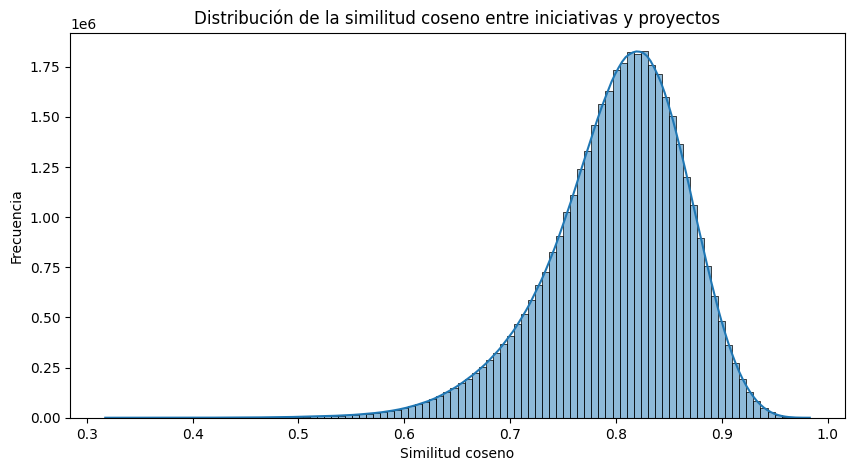

In [17]:
# Histograma de similitudes coseno
plt.figure(figsize=(10,5))
sns.histplot(df["similitud_coseno"], bins=100, kde=True)
plt.title("Distribución de la similitud coseno entre iniciativas y proyectos")
plt.xlabel("Similitud coseno")
plt.ylabel("Frecuencia")
plt.show()


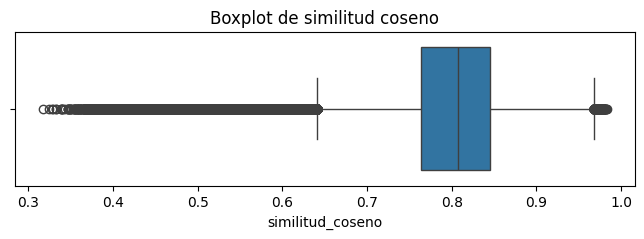

In [18]:
# Boxplot para detectar outliers y percentiles
plt.figure(figsize=(8, 2))
sns.boxplot(x=df["similitud_coseno"])
plt.title("Boxplot de similitud coseno")
plt.show()


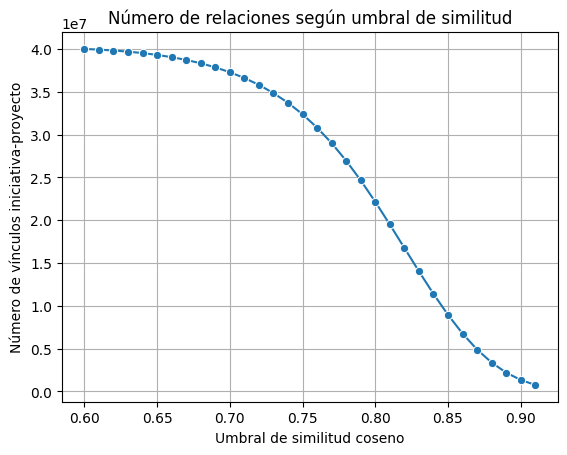

In [21]:
umbrales = np.arange(0.60, 0.91, 0.01)
conteo_por_umbral = [(u, (df["similitud_coseno"] >= u).sum()) for u in umbrales]

df_umbral = pd.DataFrame(conteo_por_umbral, columns=["umbral", "num_relaciones"])
sns.lineplot(data=df_umbral, x="umbral", y="num_relaciones", marker="o")
plt.title("Número de relaciones según umbral de similitud")
plt.xlabel("Umbral de similitud coseno")
plt.ylabel("Número de vínculos iniciativa-proyecto")
plt.grid(True)
plt.show()


In [5]:
# Filtrar las relaciones con similitud >= 0.85
df_filtrado = df[df["similitud_coseno"] >= 0.85]

# Confirmar tamaño
print(f"Número de relaciones después del filtro: {len(df_filtrado):,}")


Número de relaciones después del filtro: 8,975,258


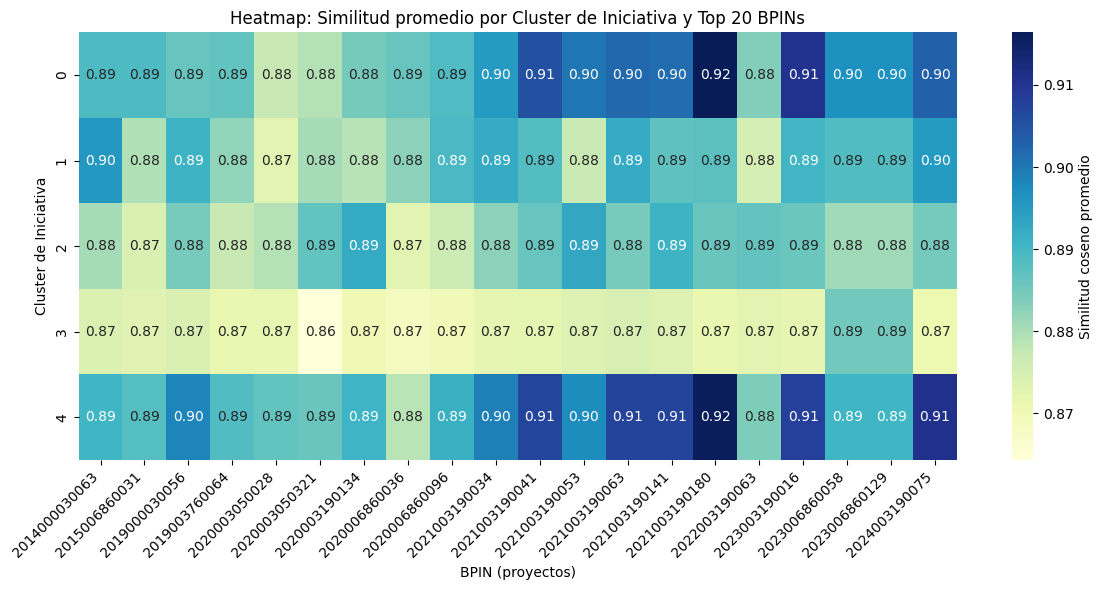

In [8]:

# Paso 1: Obtener los 20 BPIN con más relaciones
top_bpins = df_filtrado["bpin"].value_counts().head(20).index
df_top_bpins = df_filtrado[df_filtrado["bpin"].isin(top_bpins)]

# Paso 2: Calcular la similitud promedio por cluster_iniciativa y BPIN
pivot_top = (
    df_top_bpins
    .groupby(["cluster_iniciativa", "bpin"])["similitud_coseno"]
    .mean()
    .reset_index()
    .pivot(index="cluster_iniciativa", columns="bpin", values="similitud_coseno")
    .fillna(0)
)

# Paso 3: Graficar el heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_top, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Similitud coseno promedio"})
plt.title("Heatmap: Similitud promedio por Cluster de Iniciativa y Top 20 BPINs")
plt.xlabel("BPIN (proyectos)")
plt.ylabel("Cluster de Iniciativa")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



<Figure size 1400x600 with 0 Axes>

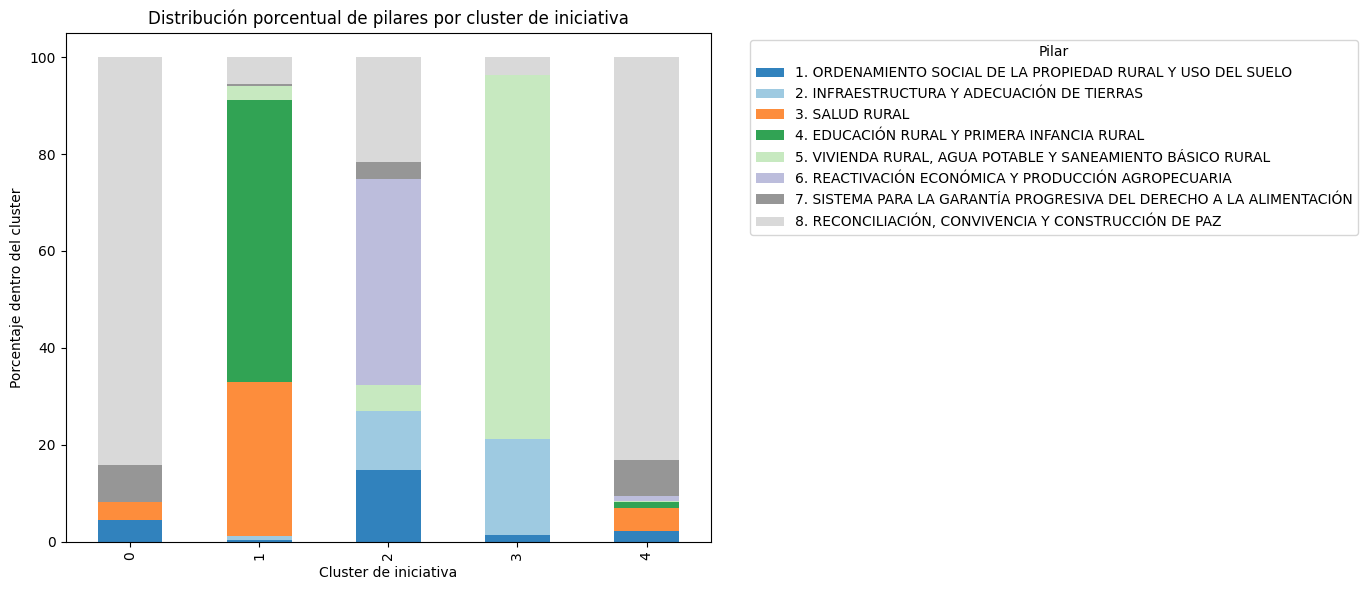

In [9]:
# Agrupar: cuántas iniciativas por cluster y pilar
tabla_pilar_cluster = (
    df_filtrado
    .groupby(["cluster_iniciativa", "pilar"])
    .size()
    .reset_index(name="cuenta")
    .pivot(index="cluster_iniciativa", columns="pilar", values="cuenta")
    .fillna(0)
)
# Normalizar por filas: porcentaje dentro de cada cluster
tabla_pilar_cluster_pct = tabla_pilar_cluster.div(tabla_pilar_cluster.sum(axis=1), axis=0) * 100

# Graficar distribución porcentual
plt.figure(figsize=(14, 6))
tabla_pilar_cluster_pct.plot(kind='bar', stacked=True, figsize=(14,6), colormap='tab20c')
plt.title("Distribución porcentual de pilares por cluster de iniciativa")
plt.ylabel("Porcentaje dentro del cluster")
plt.xlabel("Cluster de iniciativa")
plt.legend(title="Pilar", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

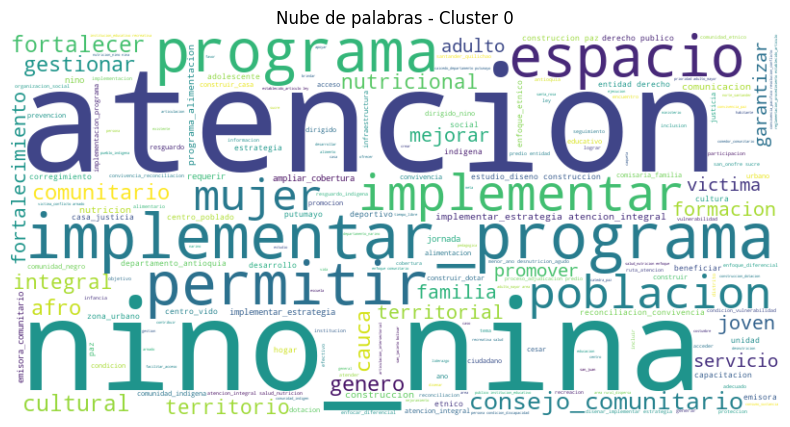

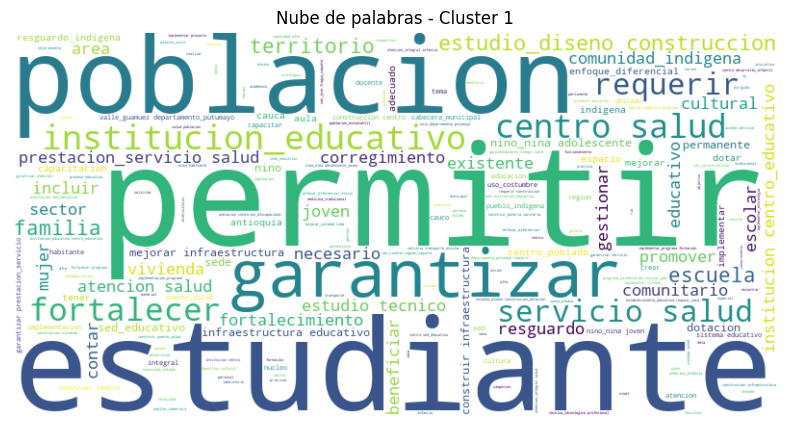

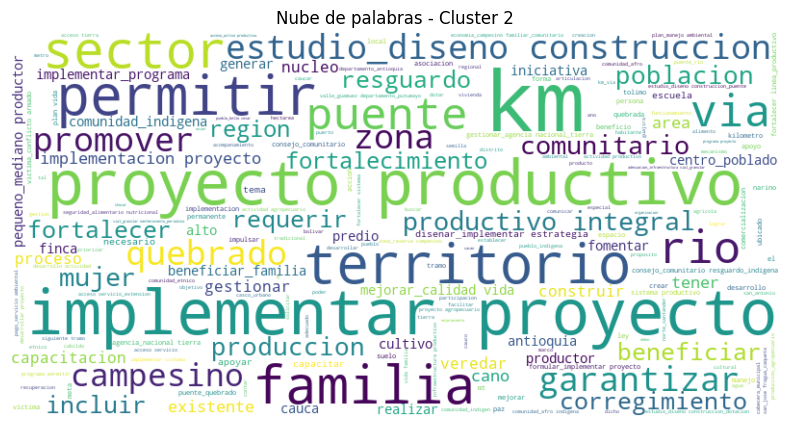

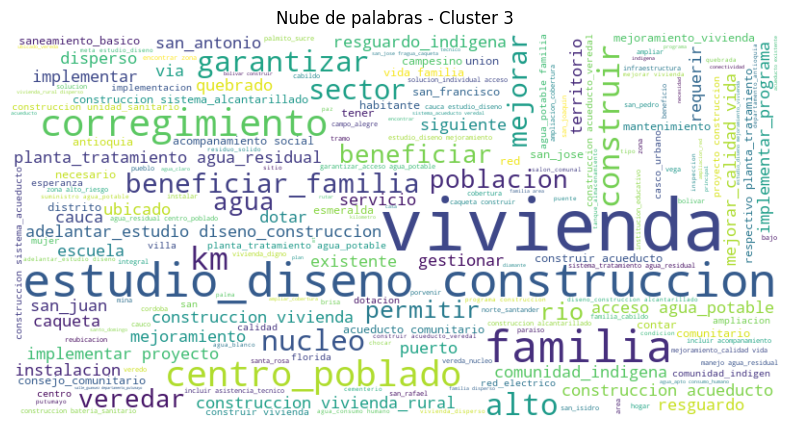

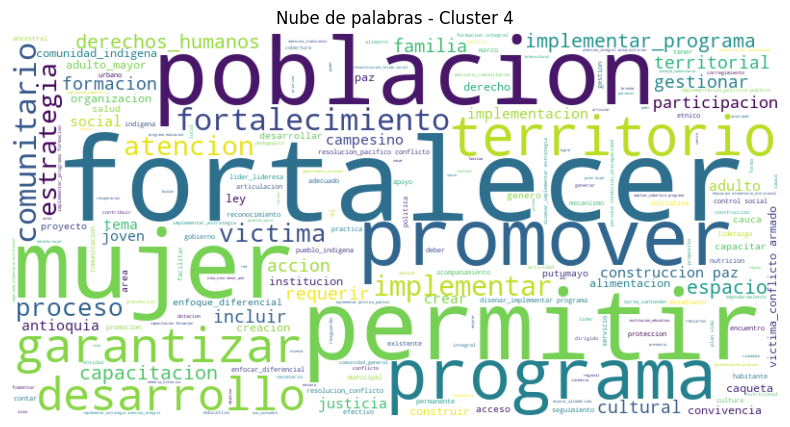

In [18]:
# Lista de palabras a excluir
palabras_excluidas = {
    "rural", "zona_rural", "municipio", "vereda", "nucleo_veredal","comunidad"
}

# Filtrar palabras específicas y prefijos
def limpiar_texto(texto):
    return " ".join([
        palabra for palabra in texto.split()
        if palabra not in palabras_excluidas and not palabra.startswith("municipio_")
    ])

# Eliminar duplicados por iniciativa
df_unicas = df.drop_duplicates(subset="codigo_iniciativa")

# Agrupar texto por cluster
textos_por_cluster = (
    df_unicas[df_unicas["texto_iniciativa"].notnull()]
    .groupby("cluster_iniciativa")["texto_iniciativa"]
    .apply(lambda x: " ".join(x))
)

# Generar nubes de palabras excluyendo ciertas palabras
for cluster_id, texto in textos_por_cluster.items():
    texto_filtrado = limpiar_texto(texto)
    if texto_filtrado.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_filtrado)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Nube de palabras - Cluster {cluster_id}")
        plt.show()
    else:
        print(f"Cluster {cluster_id} quedó sin texto después del filtrado.")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizar por cluster
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(textos_por_cluster)
feature_names = vectorizer.get_feature_names_out()

# Top 10 términos por cluster
import numpy as np

for i, row in enumerate(tfidf_matrix.toarray()):
    print(f"\nCluster {i} - Principales términos:")
    top_indices = row.argsort()[::-1][:10]
    top_terms = [(feature_names[idx], row[idx]) for idx in top_indices]
    for term, score in top_terms:
        print(f"{term}: {score:.3f}")
